Goal: Cluster AEDP dataset of 900+ sites into geographical cluster that is smaller than a state, which makes it more reasonable to be aggregated

First we use postcode data to obtain coordinate, then create clusters based on the coordinate.

This script output one excel file listing one cluster with the highest number of households that have 3 years of data from 1 Jul 2021 to 30 Jun 2023.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../../../../data/1. raw/ACAP EDP/Metadata/edp_survey_answers10569234.csv')

In [3]:
df = df[['edp_site_id', 'postcode', 'state']]

In [4]:
df

,edp_site_id,postcode,state
0,S0037,3039,VIC
1,S0057,4123,QLD
2,S0001,3040,VIC
3,S0002,2768,NSW
4,S0003,2450,NSW
...,...,...,...
950,W0349,3113,VIC
951,W0350,3047,VIC
952,W0351,2905,ACT
953,W0352,5097,SA


In [5]:
postcode = pd.read_csv('../../../../data/1. raw/ACAP EDP/Metadata/postcode data/AU.txt', sep='\t', header=None)

In [6]:
postcode = postcode[[1, 9, 10]]
col_names = ['postcode', 'lat', 'long']
postcode.columns = col_names
postcode.drop_duplicates(subset='postcode', keep = 'first', inplace=True)

In [7]:
df

,edp_site_id,postcode,state
0,S0037,3039,VIC
1,S0057,4123,QLD
2,S0001,3040,VIC
3,S0002,2768,NSW
4,S0003,2450,NSW
...,...,...,...
950,W0349,3113,VIC
951,W0350,3047,VIC
952,W0351,2905,ACT
953,W0352,5097,SA


In [8]:
postcode

,postcode,lat,long
0,2620,-35.3400,149.2280
9,2611,-35.3613,149.0570
29,2600,-35.3070,149.1390
43,2601,-35.2813,149.1293
47,2602,-35.2495,149.1635
...,...,...,...
18496,6425,-31.3208,119.1267
18498,6426,-31.4829,119.4383
18512,6427,-30.8212,119.5214
18513,6484,-30.9842,119.1085


In [9]:
df = df.merge(postcode, on='postcode', how='left')

In [10]:
df

,edp_site_id,postcode,state,lat,long
0,S0037,3039,VIC,-37.7667,144.9167
1,S0057,4123,QLD,-27.5952,153.1233
2,S0001,3040,VIC,-37.7549,144.8834
3,S0002,2768,NSW,-33.7333,150.9328
4,S0003,2450,NSW,-30.1574,153.0958
...,...,...,...,...,...
950,W0349,3113,VIC,-37.7500,145.2333
951,W0350,3047,VIC,-37.6708,144.9354
952,W0351,2905,ACT,-35.4404,149.1071
953,W0352,5097,SA,-34.8308,138.7107


In [11]:
# check missing values in df
missing_values = df.isnull().sum()

In [12]:
# show row with missing values in df
missing_rows = df[df.isnull().any(axis=1)]

In [13]:
missing_rows

,edp_site_id,postcode,state,lat,long
24,S0023,5323,SA,NaN,NaN


In [14]:
# after checking from https://auspost.com.au/postcode/5323 seems like the user inputted the wrong postcode
# so drop the row with postcode 5323
df = df[df['postcode'] != 5323]


In [15]:
df

,edp_site_id,postcode,state,lat,long
0,S0037,3039,VIC,-37.7667,144.9167
1,S0057,4123,QLD,-27.5952,153.1233
2,S0001,3040,VIC,-37.7549,144.8834
3,S0002,2768,NSW,-33.7333,150.9328
4,S0003,2450,NSW,-30.1574,153.0958
...,...,...,...,...,...
950,W0349,3113,VIC,-37.7500,145.2333
951,W0350,3047,VIC,-37.6708,144.9354
952,W0351,2905,ACT,-35.4404,149.1071
953,W0352,5097,SA,-34.8308,138.7107


In [16]:
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from sklearn.preprocessing import StandardScaler


In [17]:
# Assuming your DataFrame is df and it contains 'lat' and 'long' columns
# Convert lat and long to radians
df['lat'] = np.radians(df['lat'])
df['long'] = np.radians(df['long'])

C:\Users\z5404477\AppData\Local\Temp\ipykernel_6624\3848592116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat'] = np.radians(df['lat'])
C:\Users\z5404477\AppData\Local\Temp\ipykernel_6624\3848592116.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['long'] = np.radians(df['long'])


In [28]:
# Prepare the features for clustering (lat and long)
coords = df[['lat', 'long']].values

# Use DBSCAN with haversine distance
db = DBSCAN(eps=99, min_samples=5, metric='haversine')  # Adjust eps and min_samples as needed
# eps 0.015 produces cluster from Batemans Bay (NSW) to Coffs Harbour (NSW)
# eps 0.005 produces cluster from Avoca (NSW) to Alison (NSW)
# Fit DBSCAN to the coordinates
df['cluster'] = db.fit_predict(coords)

# Display the result
print(df.head())

  edp_site_id  postcode state       lat      long  cluster  lat_deg  long_deg
0       S0037      3039   VIC -0.659153  2.529274        0 -37.7667  144.9167
1       S0057      4123   QLD -0.481627  2.672506        0 -27.5952  153.1233
2       S0001      3040   VIC -0.658947  2.528692        0 -37.7549  144.8834
3       S0002      2768   NSW -0.588757  2.634274        0 -33.7333  150.9328
4       S0003      2450   NSW -0.526346  2.672026        0 -30.1574  153.0958


C:\Users\z5404477\AppData\Local\Temp\ipykernel_6624\3400423896.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = db.fit_predict(coords)


In [29]:
%pip install geopandas
import geopandas as gpd

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
australia_map = gpd.read_file('../../../../data/1. raw/ACAP EDP/Metadata/postcode data/AUS_2021_AUST_SHP_GDA2020/AUS_2021_AUST_GDA2020.shp')

In [31]:
import matplotlib.pyplot as plt


In [32]:
# Reverse the radians transformation to degrees for plotting
df['lat_deg'] = np.degrees(df['lat'])  # Convert back to degrees
df['long_deg'] = np.degrees(df['long'])  # Convert back to degrees

C:\Users\z5404477\AppData\Local\Temp\ipykernel_6624\1764240275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat_deg'] = np.degrees(df['lat'])  # Convert back to degrees
C:\Users\z5404477\AppData\Local\Temp\ipykernel_6624\1764240275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['long_deg'] = np.degrees(df['long'])  # Convert back to degrees


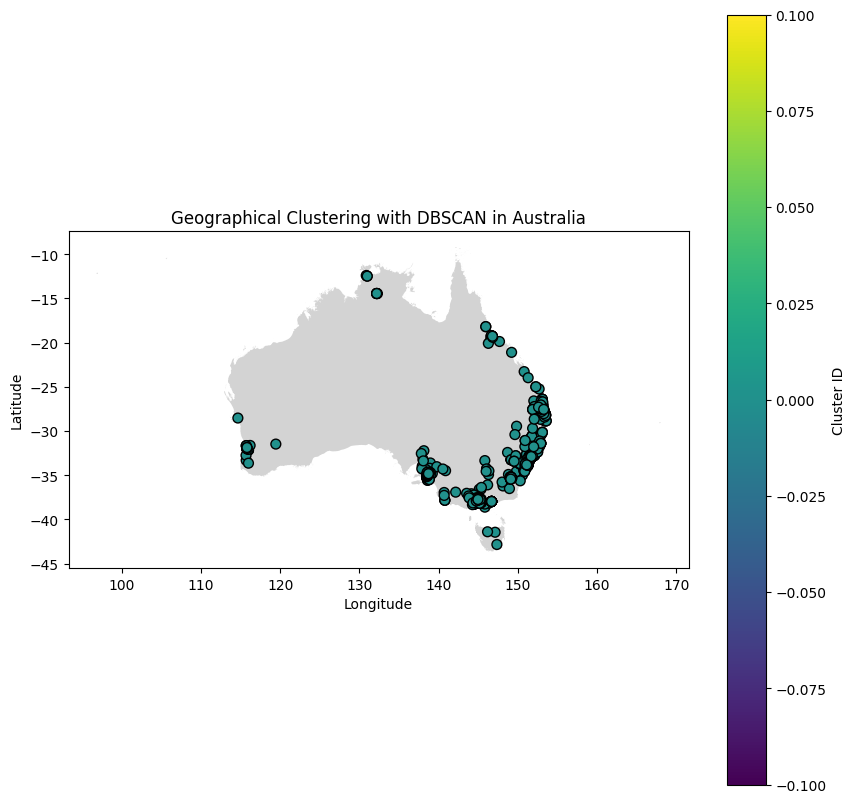

In [33]:

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Australia map
australia_map.plot(ax=ax, color='lightgray')

# Overlay the clustered data points (in degrees)
scatter = ax.scatter(df['long_deg'], df['lat_deg'], c=df['cluster'], cmap='viridis', edgecolors='k', s=50)

# Add colorbar for clusters
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Cluster ID')

# Add title and labels
ax.set_title('Geographical Clustering with DBSCAN in Australia')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [34]:
# Count the number of sites per cluster
cluster_counts = df['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'site_count']
print(cluster_counts)


   cluster  site_count
0        0         954


In [35]:
# we choose cluster 2 cuz it has the most sites
# cluster -1 is noise, so we ignore it
# Filter the DataFrame for cluster 2
cluster_2_sites = df[df['cluster'] == 2]


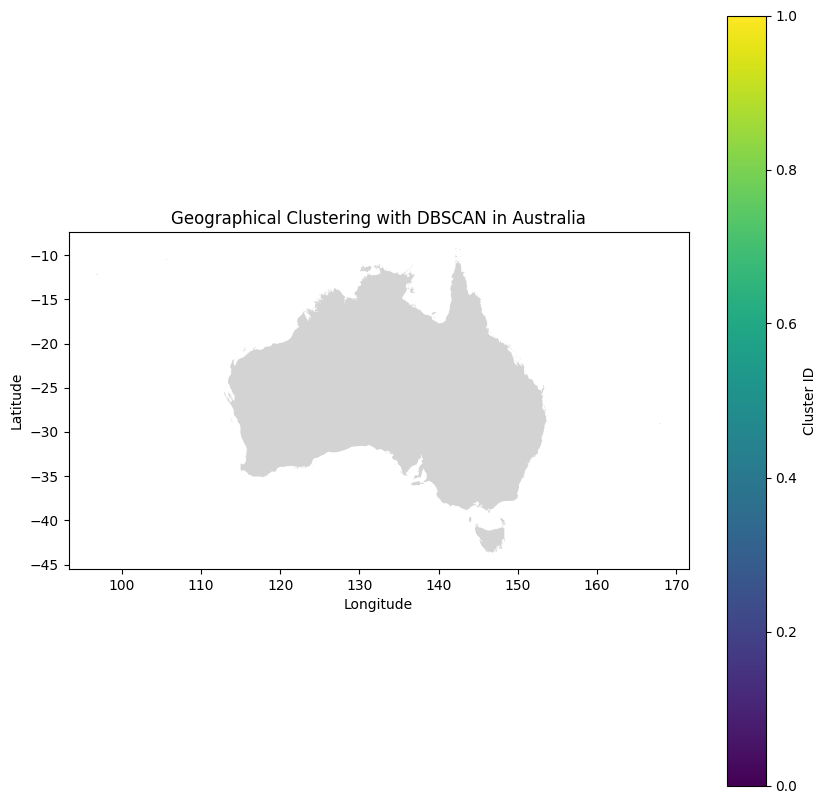

In [36]:

# display the sites in cluster 2
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Australia map
australia_map.plot(ax=ax, color='lightgray')

# Overlay the clustered data points (in degrees)
scatter = ax.scatter(cluster_2_sites['long_deg'], cluster_2_sites['lat_deg'], c=cluster_2_sites['cluster'], cmap='viridis', edgecolors='k', s=50)

# Add colorbar for clusters
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Cluster ID')

# Add title and labels
ax.set_title('Geographical Clustering with DBSCAN in Australia')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [36]:
cluster_2_sites.sort_values(by='lat_deg', ascending=True, inplace=True)

C:\Users\z5404477\AppData\Local\Temp\ipykernel_41976\484344810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2_sites.sort_values(by='lat_deg', ascending=True, inplace=True)


In [37]:
cluster_2_sites

,edp_site_id,postcode,state,lat,long,cluster,lat_deg,long_deg
189,S0191,2577,NSW,-0.604764,2.629316,2,-34.6504,150.6487
89,S0090,2529,NSW,-0.603559,2.632716,2,-34.5814,150.8435
938,W0337,2528,NSW,-0.603231,2.633194,2,-34.5626,150.8709
800,W0199,2530,NSW,-0.602889,2.631834,2,-34.5430,150.7930
36,S0035,2530,NSW,-0.602889,2.631834,2,-34.5430,150.7930
...,...,...,...,...,...,...,...,...
416,S0417,2330,NSW,-0.569635,2.637070,2,-32.6377,151.0930
294,S0295,2330,NSW,-0.569635,2.637070,2,-32.6377,151.0930
741,W0137,2420,NSW,-0.565562,2.648570,2,-32.4043,151.7519
677,W0073,2420,NSW,-0.565562,2.648570,2,-32.4043,151.7519


In [38]:
first_last_dates = pd.read_csv('../../../../data/1. raw/ACAP EDP/Metadata/edp_data_first_and_last_dates15165362.csv')

In [39]:
first_last_dates

,edp_site_id,date_of_first_data,date_of_last_data,Column1
0,S0075,"Monday, 1 January 2018","Monday, 30 September 2024",2465
1,S0081,"Monday, 1 January 2018","Monday, 30 September 2024",2465
2,S0096,"Monday, 1 January 2018","Sunday, 29 September 2024",2463
3,S0040,"Monday, 1 January 2018","Friday, 26 July 2024",2398
4,S0078,"Monday, 1 January 2018","Friday, 5 July 2024",2378
...,...,...,...,...
946,W0067,"Saturday, 19 June 2021","Wednesday, 24 August 2022",431
947,S0105,"Wednesday, 22 December 2021","Thursday, 22 December 2022",365
948,S0236,"Monday, 1 November 2021","Friday, 30 September 2022",333
949,S0484,"Thursday, 17 March 2022","Monday, 9 January 2023",298


In [40]:
cluster_2_sites = cluster_2_sites.merge(first_last_dates, on='edp_site_id', how='left')

In [41]:
cluster_2_sites.rename(columns={'Column1': 'number_of_days'}, inplace=True)

In [42]:
cluster_2_sites.sort_values(by='number_of_days', ascending=False, inplace=True)

In [43]:
cluster_2_sites

,edp_site_id,postcode,state,lat,long,cluster,lat_deg,long_deg,date_of_first_data,date_of_last_data,number_of_days
31,S0081,2233,NSW,-0.594346,2.636069,2,-34.0535,151.0356,"Monday, 1 January 2018","Monday, 30 September 2024",2465
41,S0075,2567,NSW,-0.594169,2.630777,2,-34.0434,150.7324,"Monday, 1 January 2018","Monday, 30 September 2024",2465
240,S0083,2257,NSW,-0.585223,2.641643,2,-33.5308,151.3550,"Monday, 1 January 2018","Tuesday, 30 April 2024",2312
172,S0111,2085,NSW,-0.588897,2.639036,2,-33.7413,151.2056,"Monday, 1 January 2018","Tuesday, 30 April 2024",2312
329,S0005,2320,NSW,-0.571225,2.644776,2,-32.7288,151.5345,"Monday, 1 January 2018","Tuesday, 30 April 2024",2312
...,...,...,...,...,...,...,...,...,...,...,...
269,W0174,2282,NSW,-0.575479,2.646839,2,-32.9725,151.6527,"Wednesday, 13 July 2022","Friday, 1 March 2024",597
298,S0332,2287,NSW,-0.574103,2.647492,2,-32.8937,151.6901,"Thursday, 16 September 2021","Tuesday, 31 January 2023",503
5,S0080,2530,NSW,-0.602889,2.631834,2,-34.5430,150.7930,"Wednesday, 27 October 2021","Tuesday, 21 February 2023",482
26,S0105,2570,NSW,-0.594806,2.627942,2,-34.0799,150.5700,"Wednesday, 22 December 2021","Thursday, 22 December 2022",365


In [44]:
# filter out rows with number_of_days less than 1095 #we need at least 3 years of data
cluster_2_sites_filtered = cluster_2_sites[cluster_2_sites['number_of_days'] >= 1095]

In [45]:
cluster_2_sites_filtered.sort_values(by='number_of_days', ascending=True, inplace=True)

C:\Users\z5404477\AppData\Local\Temp\ipykernel_41976\1166907172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2_sites_filtered.sort_values(by='number_of_days', ascending=True, inplace=True)


In [46]:
cluster_2_sites_filtered

,edp_site_id,postcode,state,lat,long,cluster,lat_deg,long_deg,date_of_first_data,date_of_last_data,number_of_days
325,S0008,2316,NSW,-0.572220,2.654464,2,-32.7858,152.0896,"Wednesday, 28 April 2021","Tuesday, 30 April 2024",1098
202,S0402,2155,NSW,-0.588174,2.634419,2,-33.6999,150.9411,"Saturday, 25 September 2021","Monday, 30 September 2024",1102
330,S0355,2315,NSW,-0.571213,2.655511,2,-32.7281,152.1496,"Wednesday, 22 September 2021","Monday, 30 September 2024",1104
185,W0233,2783,NSW,-0.588535,2.625494,2,-33.7206,150.4297,"Wednesday, 22 September 2021","Monday, 30 September 2024",1105
103,W0333,2040,NSW,-0.591230,2.638332,2,-33.8750,151.1653,"Tuesday, 21 September 2021","Monday, 30 September 2024",1106
...,...,...,...,...,...,...,...,...,...,...,...
172,S0111,2085,NSW,-0.588897,2.639036,2,-33.7413,151.2056,"Monday, 1 January 2018","Tuesday, 30 April 2024",2312
329,S0005,2320,NSW,-0.571225,2.644776,2,-32.7288,151.5345,"Monday, 1 January 2018","Tuesday, 30 April 2024",2312
240,S0083,2257,NSW,-0.585223,2.641643,2,-33.5308,151.3550,"Monday, 1 January 2018","Tuesday, 30 April 2024",2312
41,S0075,2567,NSW,-0.594169,2.630777,2,-34.0434,150.7324,"Monday, 1 January 2018","Monday, 30 September 2024",2465


In [47]:
#export the filtered sites to an excel file
cluster_2_sites_filtered.to_excel('../../../../data/2. processed/aedp_cluster_2_2.xlsx', index=False)

In [48]:
# Covert date_of_first_data and date_of_last_data to datetime
cluster_2_sites_filtered['date_of_first_data'] = pd.to_datetime(cluster_2_sites_filtered['date_of_first_data'])
cluster_2_sites_filtered['date_of_last_data'] = pd.to_datetime(cluster_2_sites_filtered['date_of_last_data'])

C:\Users\z5404477\AppData\Local\Temp\ipykernel_41976\2749112877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2_sites_filtered['date_of_first_data'] = pd.to_datetime(cluster_2_sites_filtered['date_of_first_data'])
C:\Users\z5404477\AppData\Local\Temp\ipykernel_41976\2749112877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_2_sites_filtered['date_of_last_data'] = pd.to_datetime(cluster_2_sites_filtered['date_of_last_data'])


In [49]:
cluster_2_sites_filtered

,edp_site_id,postcode,state,lat,long,cluster,lat_deg,long_deg,date_of_first_data,date_of_last_data,number_of_days
325,S0008,2316,NSW,-0.572220,2.654464,2,-32.7858,152.0896,2021-04-28,2024-04-30,1098
202,S0402,2155,NSW,-0.588174,2.634419,2,-33.6999,150.9411,2021-09-25,2024-09-30,1102
330,S0355,2315,NSW,-0.571213,2.655511,2,-32.7281,152.1496,2021-09-22,2024-09-30,1104
185,W0233,2783,NSW,-0.588535,2.625494,2,-33.7206,150.4297,2021-09-22,2024-09-30,1105
103,W0333,2040,NSW,-0.591230,2.638332,2,-33.8750,151.1653,2021-09-21,2024-09-30,1106
...,...,...,...,...,...,...,...,...,...,...,...
172,S0111,2085,NSW,-0.588897,2.639036,2,-33.7413,151.2056,2018-01-01,2024-04-30,2312
329,S0005,2320,NSW,-0.571225,2.644776,2,-32.7288,151.5345,2018-01-01,2024-04-30,2312
240,S0083,2257,NSW,-0.585223,2.641643,2,-33.5308,151.3550,2018-01-01,2024-04-30,2312
41,S0075,2567,NSW,-0.594169,2.630777,2,-34.0434,150.7324,2018-01-01,2024-09-30,2465


In [50]:
cluster_data = cluster_2_sites_filtered.copy()

In [51]:
# Filter first date to be from 2021-07-01 
cluster_data = cluster_data[cluster_data['date_of_first_data'] < '2021-07-01']

# Filter first date to be from 2023-06-30
cluster_data = cluster_data[cluster_data['date_of_last_data'] > '2024-06-30']
 

In [52]:
cluster_data.sort_values(by = 'date_of_last_data', ascending=True, inplace=True)

In [53]:
cluster_data

,edp_site_id,postcode,state,lat,long,cluster,lat_deg,long_deg,date_of_first_data,date_of_last_data,number_of_days
271,S0405,2282,NSW,-0.575479,2.646839,2,-32.9725,151.6527,2021-06-28,2024-07-12,1110
54,W0013,2226,NSW,-0.593401,2.636562,2,-33.9994,151.0639,2020-10-13,2024-07-12,1368
317,S0321,2322,NSW,-0.572348,2.647261,2,-32.7931,151.6769,2021-06-03,2024-07-13,1136
268,S0431,2284,NSW,-0.575620,2.646240,2,-32.9806,151.6184,2021-05-27,2024-07-16,1146
303,S0170,2307,NSW,-0.573843,2.647507,2,-32.8788,151.6910,2021-03-08,2024-07-16,1226
...,...,...,...,...,...,...,...,...,...,...,...
108,W0024,2137,NSW,-0.590914,2.637039,2,-33.8569,151.0912,2021-02-16,2024-09-30,1323
68,W0324,2170,NSW,-0.592578,2.633693,2,-33.9522,150.8995,2021-02-09,2024-09-30,1329
208,W0081,2101,NSW,-0.587907,2.640046,2,-33.6846,151.2635,2021-02-09,2024-09-30,1330
16,W0142,2519,NSW,-0.600196,2.633594,2,-34.3887,150.8938,2021-02-24,2024-09-30,1314


In [54]:
cluster_data.to_excel('../../../../data/2. processed/aedp_cluster_2_2_3years.xlsx', index=False)